In [332]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib2tikz import save as tikz_save
import subprocess
from scipy.optimize import minimize_scalar
from scipy import stats

# Price bounds induced by different methods

In [273]:
N = int(1e5)
X = np.arange(0, 1, .01)
Y = np.zeros(shape=(len(X), 2))
W = np.random.normal(size=(2, N))

bar = lambda k,x: np.sqrt(k**2 - x**2)

_p = .9
_r = .5
_qS = -.005
_qV = -.01
_sV = .2
_sS = .15
_Sh= 2*_qS/_sS
_k = 1

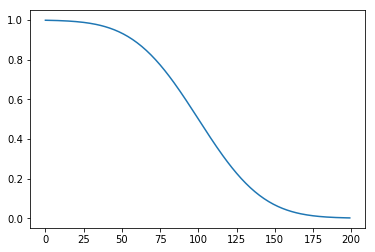

In [349]:
plt.plot(stats.norm.cdf(-np.arange(-1,1,.01)*3))
# plt.plot(stats.lognorm.pdf(np.arange(0,1,.01)*5, s=1))

C:\Users\sebastiaanv\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


(0.19611613513818402, -0.19611613052016502)

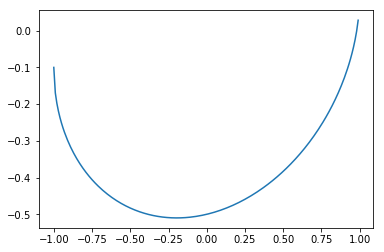

In [318]:
s = lambda x: a*x+-b*bar(1,x)#a*b+a*bar(1,x)+b*x+x*bar(1,x)
a, b = .1, .5
x = np.arange(-1,1,.01)
plt.plot(x, s(x))
a/np.sqrt(a**2+b**2), minimize_scalar(lambda x:s(x)).x

In [274]:
def simulate(Sh=_Sh, qS=_qS, qV=_qV, sS=_sS, sV=_sV, r=_r, k=_k):
    gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
    gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
    
    sigmaM_lb = np.array([qS/sS, gamma_lb])
    muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

    sigmaM_ub = np.array([qS/sS, gamma_ub])
    muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

    sigmaM = np.array([qS/sS, 0])
    muM = -.5 * sigmaM @ sigmaM.T

    sigmaV = np.array([sV*r, sV*bar(1,r)])
    muV = -qV -.5 * sigmaV @ sigmaV.T
    
    V = np.exp(muV + sigmaV @ W)
    M_lb = np.exp(muM_lb + sigmaM_lb @ W)
    M = np.exp(muM + sigmaM @ W)
    M_ub = np.exp(muM_ub + sigmaM_ub @ W)
    F = np.maximum(0, V-k)
    return V, M_lb, M, M_ub, F

### varying the correlation

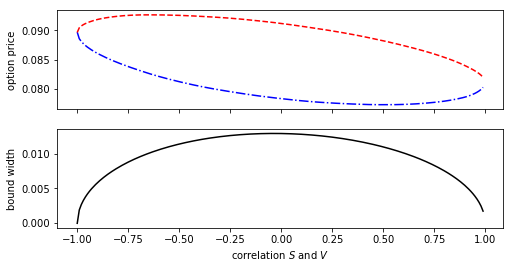

In [351]:
X = np.arange(-1, 1.0, .01)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for r, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(r=r, Sh=_Sh, k=1)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, (ax1, ax3) = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
ax1.plot(X, YF.T[0], 'b-.', X, YF.T[1], 'r--')
ax3.plot(X, YF[:,1] - YF[:,0], 'k');
ax1.set_ylabel('option price')
ax3.set_ylabel('bound width')
ax3.set_xlabel('correlation $S$ and $V$')

# tikz_save('../scriptie/img/varycorrelation.tex', figureheight='1.5in', figurewidth='4in')
# print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push', shell=True).decode('utf-8'))

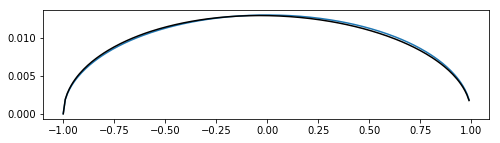

In [363]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(X, np.sqrt(1-np.power(X,2))/77)
ax.plot(X, YF[:,1] - YF[:,0], 'k');

### Varying the unobserved return process

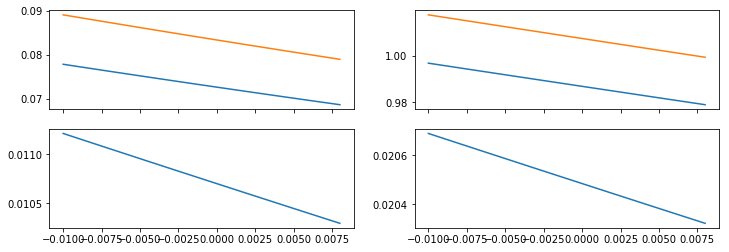

In [232]:
X = np.arange(_qS, -_qS, .001)*2
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for qV, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(qV=qV)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

### Varying the unobserved volatility process

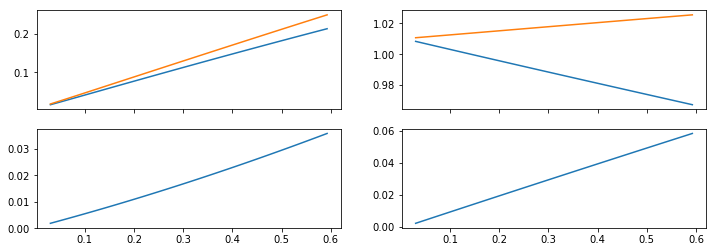

In [296]:
X = np.arange(.2*_sS, 4*_sS, _sS/20)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for sV, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(sV=sV)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);


### Varying the strike

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{groupplots}


CalledProcessError: Command 'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push' returned non-zero exit status 1.

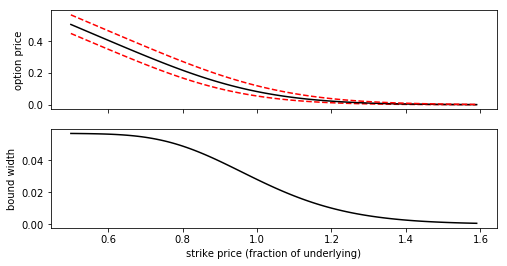

In [258]:
X = np.arange(.5,1.6,.01)
YF = np.zeros((len(X), 3))

for k, YFi in zip(X, YF):
    V, M_lb, M, M_ub, F = simulate(k=k, Sh=5*_Sh)
    YFi += np.array([np.mean(M_lb*F), np.mean(M*F), np.mean(M_ub*F)])

fix, (ax1, ax3) = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
ax1.plot(X, YF.T[0], 'r--', X, YF.T[1], 'k-', X, YF.T[2], 'r--', )
ax3.plot(X, YF[:,1] - YF[:,0], 'k');
ax3.set_xlabel('strike price (fraction of underlying)')
ax1.set_ylabel('option price')
ax3.set_ylabel('bound width')

tikz_save('../scriptie/img/varystrike.tex', figureheight='1.5in', figurewidth='4in')
print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push', shell=True).decode('utf-8'))

### Varying the sharpe ratio limit

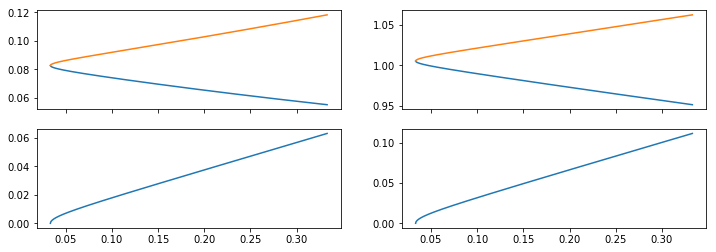

In [292]:
X = -_qS/_sS*np.arange(1, 10, .01)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for Sh, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(Sh=Sh)
    
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

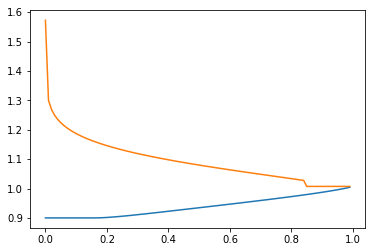

In [223]:
for p, yi in zip(X, Y):
    x = np.maximum(k, np.exp(mux + sigmax @ W))
    #percentile bounds
    yi += np.mean(x[x <= np.percentile(x, 100*p)]), np.mean(x[-x <= np.percentile(-x, 100*p)])

plt.plot(X,Y)

In [155]:
w = np.random.normal(size=(int(1e7),))
mx, sx = 1,.02 
sm = .6
mm = 0
p = .1
x = np.exp(mx + sx*w)
m = np.exp(mm + sm*w)
# ESl = np.mean(x[x <= np.percentile(x, 100*p)])
ESu = np.mean(x[-x <= np.percentile(-x, 100*p)])
ESm = np.mean((x*m)[-x*m <= np.percentile(-x*m, 100*p)])
smb = np.sqrt((np.log(ESu)-mx)*2)-sx
print(f'''{ESl:9.5f}
{ESu:9.5f}
{ESm:9.5f}
{np.mean(m*x):9.5f}

{np.exp(mm+mx+(sm+sx)**2/2):9.5f}
{-np.percentile(-x, 100*p):9.5f}
{smb:9.5f}
''')

  2.62458
  2.81546
  8.37029
  3.29338

  3.29432
  2.78880
  0.24505



In [177]:
import progressbar
bar = progressbar.ProgressBar()

w = np.random.normal(size=(int(1e5),))

X = np.arange(.1, 5,.1)
Y = np.zeros((len(X), 4))
mx, sx = 0,.02 
p = .001

for i, sx in enumerate(X):
    x = np.exp(mx + sx*w)
    ESx = np.mean(x[-x <= np.percentile(-x, 100*p)])
    f = np.maximum(x - np.exp(mx + sx**2/2), 0)
    ESf = np.mean(f[-f <= np.percentile(-f, 100*p)])
    Y[i] = ESx, ESf, np.sqrt((np.log(ESx)-mx)*2)-sx, 0


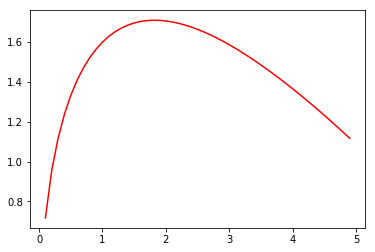

In [178]:
plt.plot(X,Y[:,2], 'r')

# plt.plot(X, np.power(X,1/3), 'k')

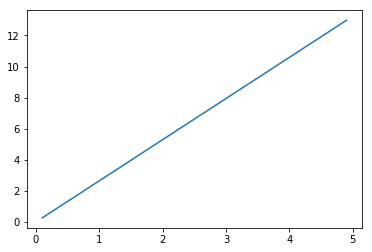

In [25]:

w = np.random.normal(size=(int(1e5),))

X = np.arange(.1, 5,.1)
Y = np.zeros((len(X), ))
mx, sx = 0,.02 
p = .01

for i, sx in enumerate(X):
    x = sx*w
    Y[i] = np.mean(x[-x <= np.percentile(-x, 100*p)])
    
plt.plot(X,Y)

In [20]:
x = np.random.normal(0, 1, size=int(1e6))
es = lambda x: np.mean(x[x < np.percentile(x, 5)])
es(-x), -es(x)

(-2.0670078887025833, 2.0663440657941887)